# Reading data

In [2]:
#Importing all the necessary liberaries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os

In [9]:
reviews=pd.read_csv('train.csv')
reviews.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [11]:
reviews=reviews.drop("Browser_Used", axis=1)
reviews.head()

,User_ID,Description,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Tablet,not happy


In [13]:
reviews=reviews.drop("Device_Used", axis=1)
reviews.head()

,User_ID,Description,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy
2,id10328,I booked this hotel through Hotwire at the low...,not happy
3,id10329,Stayed here with husband and sons on the way t...,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,not happy


In [15]:
reviews = pd.get_dummies(reviews, columns = ["Is_Response"],drop_first=True)
reviews.head()

,User_ID,Description,Is_Response_not happy
0,id10326,The room was kind of clean but had a VERY stro...,1
1,id10327,I stayed at the Crown Plaza April -- - April -...,1
2,id10328,I booked this hotel through Hotwire at the low...,1
3,id10329,Stayed here with husband and sons on the way t...,0
4,id10330,My girlfriends and I stayed here to celebrate ...,1


# Clean Data

In [20]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews["review_clean"] = reviews["Description"].apply(lambda x: clean_text(x))

Wall time: 12min 24s


In [21]:
reviews.head()

,User_ID,Description,Is_Response_not happy,review_clean
0,id10326,The room was kind of clean but had a VERY stro...,1,room kind clean strong smell dog generally ave...
1,id10327,I stayed at the Crown Plaza April -- - April -...,1,stay crown plaza april april staff friendly at...
2,id10328,I booked this hotel through Hotwire at the low...,1,booked hotel hotwire low price could find got ...
3,id10329,Stayed here with husband and sons on the way t...,0,stayed husband son way alaska cruise love hote...
4,id10330,My girlfriends and I stayed here to celebrate ...,1,girlfriend stay celebrate th birthday plan wee...


In [22]:
reviews= reviews.drop("Description",axis=1)
reviews.head()

,User_ID,Is_Response_not happy,review_clean
0,id10326,1,room kind clean strong smell dog generally ave...
1,id10327,1,stay crown plaza april april staff friendly at...
2,id10328,1,booked hotel hotwire low price could find got ...
3,id10329,0,stayed husband son way alaska cruise love hote...
4,id10330,1,girlfriend stay celebrate th birthday plan wee...


In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review_clean"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

In [26]:
# add number of characters column
reviews["nb_chars"] = reviews["review_clean"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["review_clean"].apply(lambda x: len(x.split(" ")))

In [27]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews = pd.concat([reviews, doc2vec_df], axis=1)

In [28]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

In [29]:
reviews.head()

,User_ID,Is_Response_not happy,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_zabar,word_zabars,word_zaza,word_zealand,word_zebra,word_zen,word_zero,word_zip,word_zone,word_zoo
0,id10326,1,room kind clean strong smell dog generally ave...,0.000,0.457,0.543,0.9501,134,21,-0.020124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,id10327,1,stay crown plaza april april staff friendly at...,0.021,0.839,0.139,0.8957,621,98,-0.435516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,id10328,1,booked hotel hotwire low price could find got ...,0.075,0.760,0.165,0.9118,774,115,-0.348010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,id10329,0,stayed husband son way alaska cruise love hote...,0.020,0.506,0.474,0.9897,320,51,-0.277380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,id10330,1,girlfriend stay celebrate th birthday plan wee...,0.062,0.762,0.176,0.9497,903,132,-0.355143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
reviews.shape

(38932, 8677)

# Exploratory data analysis

In order to have a better understanding of our data, let's explore it a little:

In [32]:
# show Is_Response_not happy distribution
reviews["Is_Response_not happy"].value_counts(normalize = True)

0    0.681213
1    0.318787
Name: Is_Response_not happy, dtype: float64

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

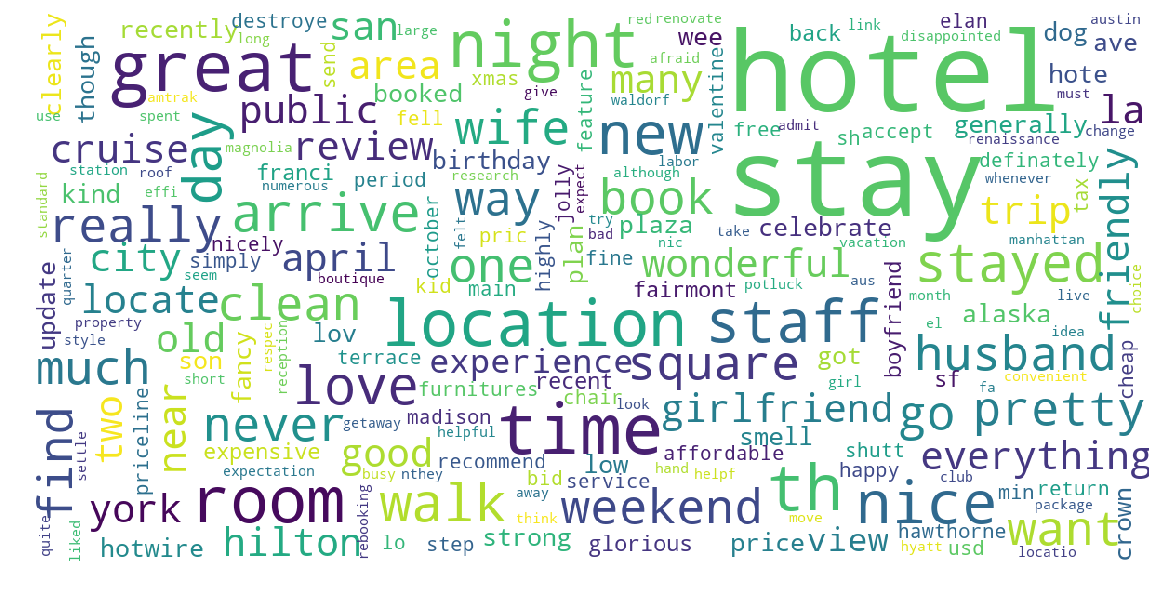

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews["review_clean"])

In [ ]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

In [ ]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

# Model Building

In [51]:
# feature selection
label = "Is_Response_not happy"
ignore_cols = [label, "review_clean"]
features = [c for c in reviews.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews[features], reviews[label], test_size = 0.20, random_state = 42)

In [53]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

In [54]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

We can see that the precision decreases when we increase the recall. This shows us that we have to choose a prediction thresold adapted to our needs. If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. On the contrary, if we want to be really confident about our predictions but don't mind about not finding all the positive observations, we should set a high thresold that will get us a high precision and a low recall.

In order to know if our model performs better than another classifier, we can simply use the AP metric. To assess the quality of our model, we can compare it to a simple decision baseline. Let's take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.

Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.35, which is more than 8 times higher than the AP of the random method. This means that our model has a good predictive power.